## 数据导入

In [1]:
import numpy as np
import pandas as pd
dataset = pd.read_csv(r'C:\Users\Alchemist\Documents\myProject\datasets\data.csv', header=0,
                      usecols = range(0, 32, 1))

## 数据展示

In [2]:
from sklearn import preprocessing
from collections import Counter
encoder = preprocessing.LabelEncoder().fit(dataset['diagnosis'])
dataset['diagnosis'] = encoder.transform(dataset['diagnosis'])
print('标签: %s' % encoder.classes_)
print('标签值标准化: %s' % encoder.transform(['benign', 'malignant']))
X = np.array(dataset)
dataset_target = X[:, 1]
dataset_data = X[:, 2:32]
print(Counter(dataset_target))

标签: ['benign' 'malignant']
标签值标准化: [0 1]
Counter({0.0: 357, 1.0: 212})


## 数据均衡：SMOTEENN

In [3]:
from imblearn.combine import SMOTEENN
smo = SMOTEENN()
dataset_data_sm, dataset_target_sm = smo.fit_resample(dataset_data, dataset_target)
Counter(dataset_target_sm)

Counter({0.0: 315, 1.0: 310})

## 数据标准化

In [5]:
from sklearn import preprocessing
import numpy as np
dataset_data_scaled = preprocessing.scale(dataset_data_sm)

## adaboost

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
# features and lanbels
X = dataset_data_scaled
Y = dataset_target_sm
# split data into train and test set
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = 9)
#fit modle on training data
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), random_state=90, n_estimators = 61)
model.fit(X_train, y_train)
# make predictions on test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred] # float -> integer
#evaluate
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.60%


## 展示特征重要性

Feature Ranking
(21) texture_worst  0.139860
(7) concave points_mean  0.082064
(6) concavity_mean  0.071890
(22) perimeter_worst  0.064285
(1) texture_mean  0.060239
(10) radius_se  0.053412
(14) smoothness_se  0.050678
(17) concave points_se  0.048948
(13) area_se  0.040702
(8) symmetry_mean  0.036357


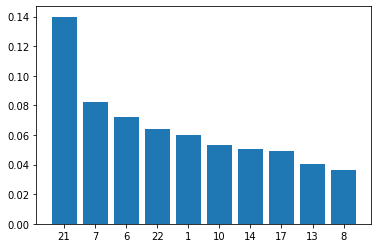

In [33]:
import matplotlib.pyplot as plt
importances = model.feature_importances_
# sort
index = np.argsort(importances)[::-1]
print("Feature Ranking")
for i in range(0, 10):
    print("(%d) %s  %f" % (index[i], dataset.columns[index[i]+2], importances[index[i]]))
plt.bar(range(10), importances[index][0:10])
plt.xticks(range(10), index)
plt.savefig(r'C:\Users\Alchemist\Documents\myProject\ppt\pictures\adaboost\imp.png')

others  0.318272
texture_worst  0.139860
concave points_mean  0.082064
concavity_mean  0.071890
perimeter_worst  0.064285
texture_mean  0.060239
radius_se  0.053412
smoothness_se  0.050678
concave points_se  0.048948
area_se  0.040702
symmetry_mean  0.036357
texture_se  0.033292


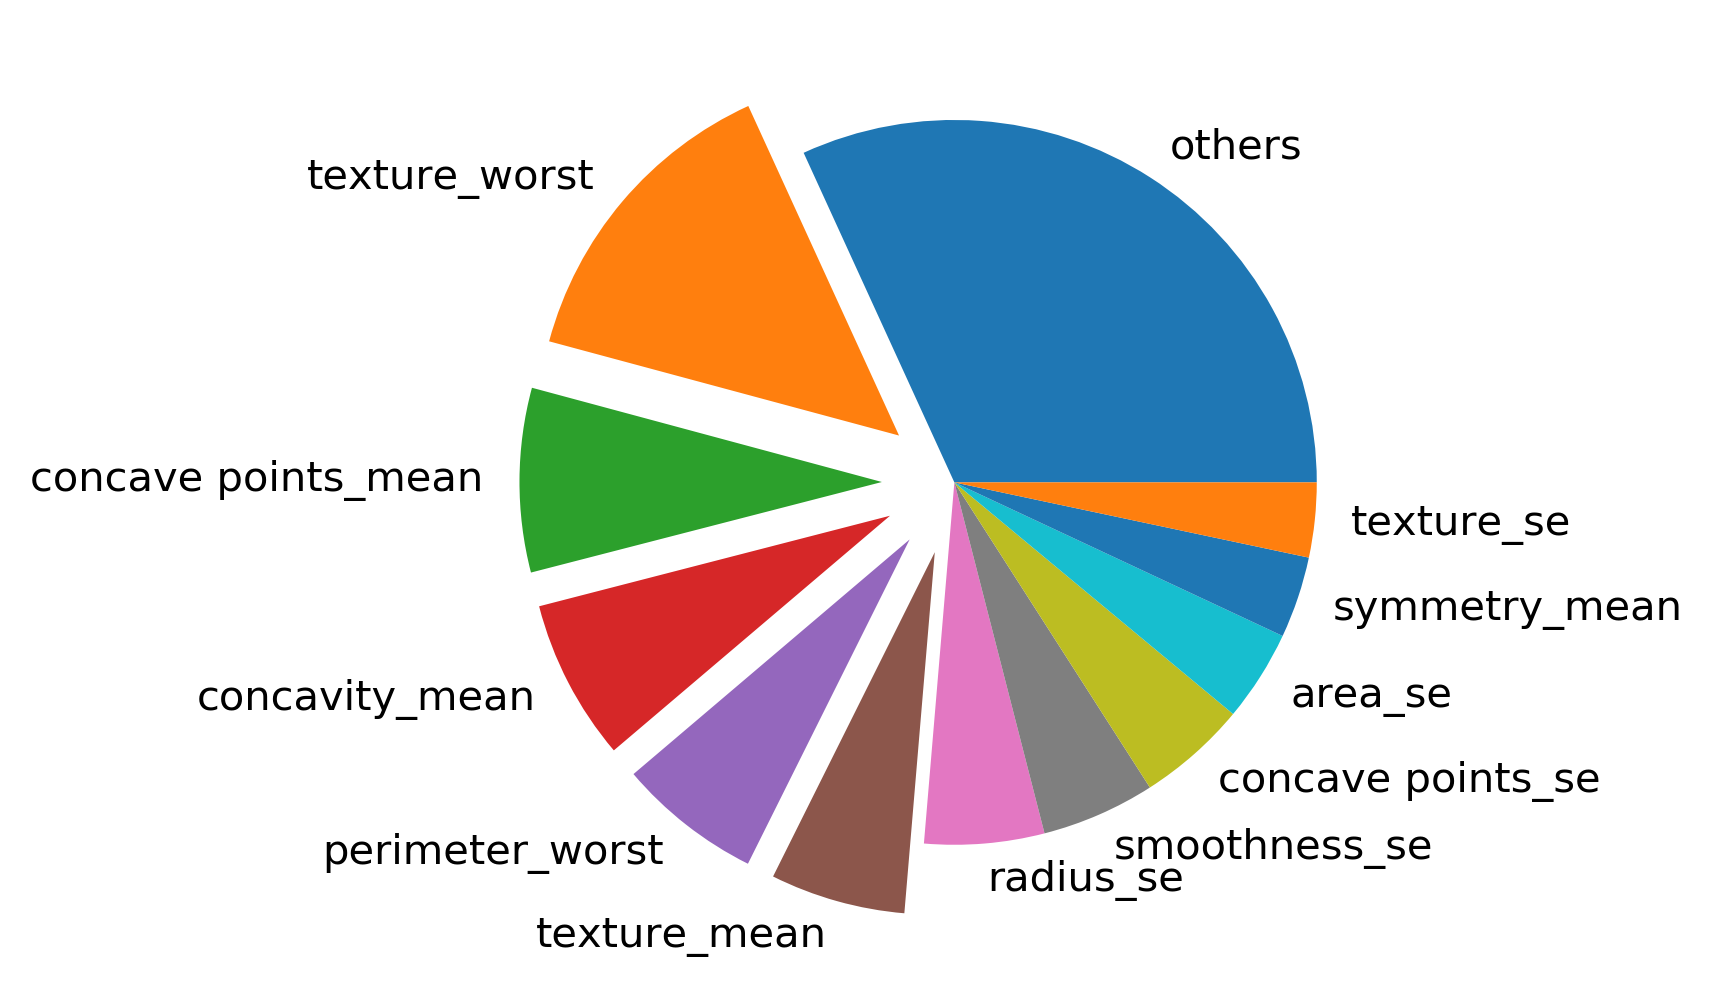

In [35]:
labels = ["others"]
values = [0]
explode = [0]
for i in range(0, 30):
    #print("(%d) %s  %f" % (index[i], dataset.columns[index[i]+2], importances[index[i]]))
    if i < 11:
        labels.append(dataset.columns[index[i]+2])
        values.append(importances[index[i]])
        if i < 5:
            explode.append(0.2)
        else:
            explode.append(0)
    else:
        values[0] = values[0] + importances[index[i]]
for i in range(12):
    print("%s  %f" % (labels[i], values[i]))
#plt.bar(range(11), values)
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.pie(values,labels=labels, explode=explode)
plt.savefig(r"C:\Users\Alchemist\Documents\myProject\ppt\pictures\adaboost\pie.png")

## 单个决策树对照
记得改之前的

In [13]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 2, criterion = 'entropy')
clf.fit(X_train, y_train)
ans = clf.predict(X_test)
predictions = [(value) for value in ans] # float -> integer

accuracy = accuracy_score(y_test, predictions)
cnt = 0
for i in range(len(y_test)):
    if abs(ans[i] - y_test[i]) < 1e-1:
        cnt += 1
    c = (cnt / len(y_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.41%


## 查看训练过程

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# features and lanbels
X = dataset_data_scaled
Y = dataset_target_sm
# split data into train and test set
seed = 6
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = seed)
#fit modle on training data
model = AdaBoostClassifier()
model.fit(X_train, y_train, 
          early_stopping_rounds = 10,
          eval_set=[(X_train, y_train)],
          eval_metric='logloss',
          verbose=True) # 验证集误差迭代10次不会降低，就停止
# make predictions on test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred] # float -> integer
#evaluate
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

TypeError: fit() got an unexpected keyword argument 'early_stopping_rounds'

## n_estimators和max_depth如何影响分类效果

In [13]:
from sklearn.model_selection import train_test_split

def Get_Average(list):
    sum = 0
    for num in list:
        sum += num
    avg = sum / len(list)
    return avg

accuracy = []
max_depth_test = np.arange(2, 11)
estimators_test = np.arange(2, 200, 2)
max_accuracy, best_depth, best_estimators_num = (0.0, 2, 2)
for depth in max_depth_test:
    for estimators in estimators_test:
        current = []
        for r in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = r)
            clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth),
                                     random_state=90, n_estimators = estimators)
            clf.fit(X_train, y_train)
            ans = clf.predict(X_test)
            cnt = 0
            for i in range(len(y_test)):
                if ans[i] == y_test[i]:
                    cnt += 1
            c = cnt / len(y_test)
            current.append(c)
        avg = Get_Average(current)
        if avg > max_accuracy:
            max_accuracy = avg
            best_depth = depth
            best_estimators_num = estimators
        accuracy.append(avg)
        print("max_depth = %d  n_estimators = %d  accuracy = %f%%" % (depth, estimators, avg*100))

max_depth = 2  n_estimators = 2  accuracy = 93.426573%
max_depth = 2  n_estimators = 4  accuracy = 94.685315%
max_depth = 2  n_estimators = 6  accuracy = 95.524476%
max_depth = 2  n_estimators = 8  accuracy = 95.944056%
max_depth = 2  n_estimators = 10  accuracy = 95.804196%
max_depth = 2  n_estimators = 12  accuracy = 96.083916%
max_depth = 2  n_estimators = 14  accuracy = 95.664336%
max_depth = 2  n_estimators = 16  accuracy = 96.083916%
max_depth = 2  n_estimators = 18  accuracy = 95.804196%
max_depth = 2  n_estimators = 20  accuracy = 95.944056%
max_depth = 2  n_estimators = 22  accuracy = 96.363636%
max_depth = 2  n_estimators = 24  accuracy = 96.363636%
max_depth = 2  n_estimators = 26  accuracy = 96.503497%
max_depth = 2  n_estimators = 28  accuracy = 96.363636%
max_depth = 2  n_estimators = 30  accuracy = 95.804196%
max_depth = 2  n_estimators = 32  accuracy = 95.804196%
max_depth = 2  n_estimators = 34  accuracy = 96.083916%
max_depth = 2  n_estimators = 36  accuracy = 95.9440

max_depth = 3  n_estimators = 96  accuracy = 97.762238%
max_depth = 3  n_estimators = 98  accuracy = 97.762238%
max_depth = 3  n_estimators = 100  accuracy = 97.482517%
max_depth = 3  n_estimators = 102  accuracy = 97.482517%
max_depth = 3  n_estimators = 104  accuracy = 97.482517%
max_depth = 3  n_estimators = 106  accuracy = 97.482517%
max_depth = 3  n_estimators = 108  accuracy = 97.482517%
max_depth = 3  n_estimators = 110  accuracy = 97.622378%
max_depth = 3  n_estimators = 112  accuracy = 97.482517%
max_depth = 3  n_estimators = 114  accuracy = 97.762238%
max_depth = 3  n_estimators = 116  accuracy = 97.762238%
max_depth = 3  n_estimators = 118  accuracy = 98.041958%
max_depth = 3  n_estimators = 120  accuracy = 97.902098%
max_depth = 3  n_estimators = 122  accuracy = 97.902098%
max_depth = 3  n_estimators = 124  accuracy = 97.902098%
max_depth = 3  n_estimators = 126  accuracy = 97.902098%
max_depth = 3  n_estimators = 128  accuracy = 98.041958%
max_depth = 3  n_estimators = 130

max_depth = 4  n_estimators = 188  accuracy = 97.762238%
max_depth = 4  n_estimators = 190  accuracy = 97.622378%
max_depth = 4  n_estimators = 192  accuracy = 97.622378%
max_depth = 4  n_estimators = 194  accuracy = 97.622378%
max_depth = 4  n_estimators = 196  accuracy = 97.622378%
max_depth = 4  n_estimators = 198  accuracy = 97.622378%
max_depth = 5  n_estimators = 2  accuracy = 93.986014%
max_depth = 5  n_estimators = 4  accuracy = 94.545455%
max_depth = 5  n_estimators = 6  accuracy = 95.384615%
max_depth = 5  n_estimators = 8  accuracy = 95.524476%
max_depth = 5  n_estimators = 10  accuracy = 95.664336%
max_depth = 5  n_estimators = 12  accuracy = 95.664336%
max_depth = 5  n_estimators = 14  accuracy = 95.944056%
max_depth = 5  n_estimators = 16  accuracy = 96.083916%
max_depth = 5  n_estimators = 18  accuracy = 96.643357%
max_depth = 5  n_estimators = 20  accuracy = 96.363636%
max_depth = 5  n_estimators = 22  accuracy = 96.783217%
max_depth = 5  n_estimators = 24  accuracy = 9

max_depth = 6  n_estimators = 84  accuracy = 96.503497%
max_depth = 6  n_estimators = 86  accuracy = 96.503497%
max_depth = 6  n_estimators = 88  accuracy = 96.643357%
max_depth = 6  n_estimators = 90  accuracy = 96.643357%
max_depth = 6  n_estimators = 92  accuracy = 96.503497%
max_depth = 6  n_estimators = 94  accuracy = 96.643357%
max_depth = 6  n_estimators = 96  accuracy = 96.643357%
max_depth = 6  n_estimators = 98  accuracy = 96.503497%
max_depth = 6  n_estimators = 100  accuracy = 96.503497%
max_depth = 6  n_estimators = 102  accuracy = 96.643357%
max_depth = 6  n_estimators = 104  accuracy = 96.643357%
max_depth = 6  n_estimators = 106  accuracy = 96.643357%
max_depth = 6  n_estimators = 108  accuracy = 96.783217%
max_depth = 6  n_estimators = 110  accuracy = 96.643357%
max_depth = 6  n_estimators = 112  accuracy = 96.643357%
max_depth = 6  n_estimators = 114  accuracy = 96.643357%
max_depth = 6  n_estimators = 116  accuracy = 96.643357%
max_depth = 6  n_estimators = 118  accu

max_depth = 7  n_estimators = 180  accuracy = 95.244755%
max_depth = 7  n_estimators = 182  accuracy = 95.244755%
max_depth = 7  n_estimators = 184  accuracy = 95.244755%
max_depth = 7  n_estimators = 186  accuracy = 95.244755%
max_depth = 7  n_estimators = 188  accuracy = 95.244755%
max_depth = 7  n_estimators = 190  accuracy = 95.244755%
max_depth = 7  n_estimators = 192  accuracy = 95.244755%
max_depth = 7  n_estimators = 194  accuracy = 95.244755%
max_depth = 7  n_estimators = 196  accuracy = 95.244755%
max_depth = 7  n_estimators = 198  accuracy = 95.244755%
max_depth = 8  n_estimators = 2  accuracy = 95.244755%
max_depth = 8  n_estimators = 4  accuracy = 95.244755%
max_depth = 8  n_estimators = 6  accuracy = 95.244755%
max_depth = 8  n_estimators = 8  accuracy = 95.244755%
max_depth = 8  n_estimators = 10  accuracy = 95.244755%
max_depth = 8  n_estimators = 12  accuracy = 95.244755%
max_depth = 8  n_estimators = 14  accuracy = 95.244755%
max_depth = 8  n_estimators = 16  accuracy

## 画出折线图

(7, 99)


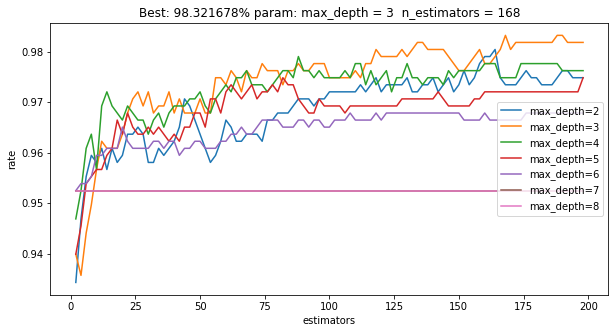

In [14]:
import matplotlib.pyplot as plt
params_values = np.zeros(len(accuracy)).reshape(len(max_depth_test), len(estimators_test))
print(params_values.shape)
for i in range(len(accuracy)):
    params_values[int(i / len(estimators_test)), int(i % len(estimators_test))] = accuracy[i]
fig = plt.figure(figsize = (10, 5))
for i in range(params_values.shape[0]):
    plt.plot(estimators_test, params_values[i], label = "max_depth=" + str(i+2))
plt.xlabel('estimators')
plt.ylabel('rate')
plt.title("Best: %f%% param: max_depth = %d  n_estimators = %d" % (max_accuracy*100, best_depth, best_estimators_num))
plt.legend(loc = 'right')

plt.savefig('C:\\Users\\Alchemist\\Documents\\myProject\\ppt\\pictures\\adaboost\\polygon1all.png')

## max_depth对分类效果的影响

0.9832550860719875 1


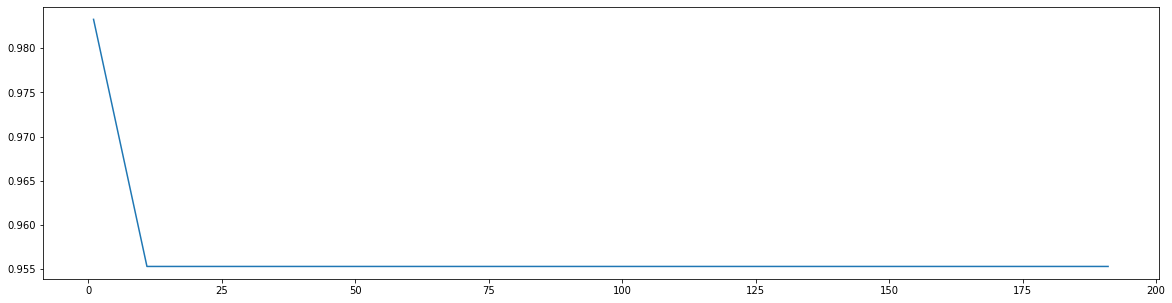

In [72]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
scorel = []
for i in range(0,200,10):
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i+1), 
                             random_state=90, n_estimators = 100)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

0.9832550860719875 1


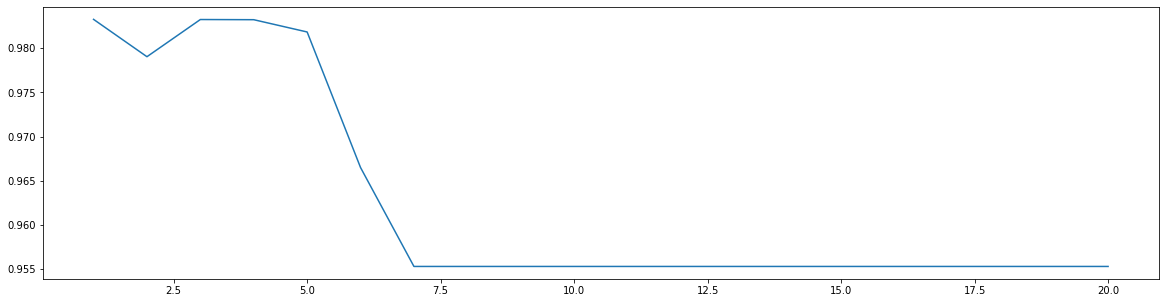

In [76]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
scorel = []
for i in range(0,20,1):
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i+1), 
                             random_state=90, n_estimators = 100)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))+1))
plt.figure(figsize=[20,5])
plt.plot(range(1,21,1),scorel)
plt.show()

0.9888302034428795 71


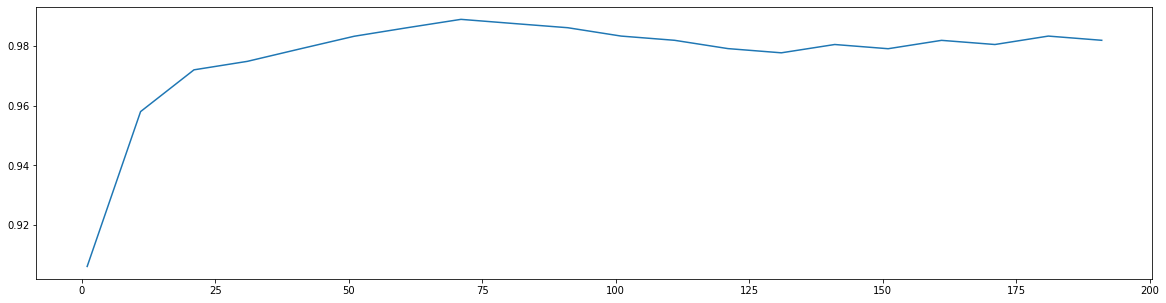

In [78]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
scorel = []
for i in range(0,200,10):
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                             random_state=90, n_estimators = i+1)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

0.9888302034428795 63


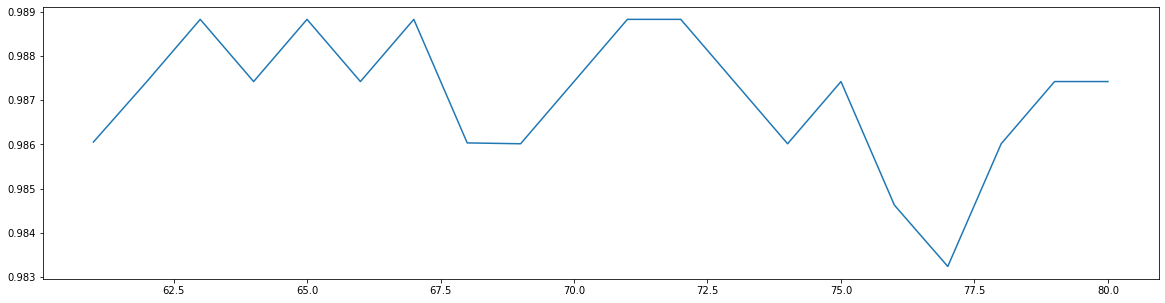

In [82]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
scorel = []
for i in range(60,80,1):
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                             random_state=90, n_estimators = i+1)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))+61))
plt.figure(figsize=[20,5])
plt.plot(range(61,81,1),scorel)
plt.show()